In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error


from sklearn.feature_selection import SelectFromModel #RFE 
from sklearn.metrics import classification_report

from scipy.stats.stats import pearsonr


from mpl_toolkits.axes_grid1 import AxesGrid


# supress some warnings that mess up my slides
import warnings; warnings.simplefilter('ignore')

# COMP6200 Portfolio 2

The goal of the second portfolio is to reproduce some work on predicting the energy usage of a house based on Internet of Things (IoT) measurements of temperature and humidity and weather observations.

__Introduction:__ the electricity consumption in domestic buildings is explained by two main factors: the type and number of electrical appliances and the use of the appliances by the occupants. Naturally, both factors are interrelated. The domestic appliances use by the occupants would leave traceable signals in the indoor environment near the vicinity of the appliance, for example: the temperature, humidity, vibrations, light and noise. The occupancy level of the building in different locations could also help to determine the use of the appliances. In this work, the prediction was carried out using different data sources and environmental parameters (indoor and outdoor conditions). Specifically, data from a nearby airport weather station, temperature and humidity in different rooms in the house from a wireless sensor network and one sub-metered electrical energy consumption (lights) have been used to predict the energy use by appliances.

This work explores several questions. Is the weather data obtained from a nearby weather station representative enough to improve the appliances energy consumption prediction? Can the temperature and humidity measurements from a wireless network help in the energy prediction? From all the data used in prediction models, which parameters are the most important in energy prediction?

In [10]:
testing = pd.read_csv('data/testing.csv', index_col='date', parse_dates=True)
#testing.head() #4932 rows × 31 columnss


In [11]:
training = pd.read_csv('data/training.csv', index_col='date', parse_dates=True)
#training.head()#14803 rows × 31 columns

In [12]:
#combine testing and training to new dataframe 'data'
data = pd.concat([training, testing] , axis=0)
data.head()

data.shape

(19735, 31)

In [5]:
#training['Date'] = training.index
#convert datetime index to month format
#training['Month'] = training.index.strftime("%d %B, %Y")
#training.index = training.index.strftime("%B %Y")
#date_time.strftime("%d %B, %Y")

__Dataset and Exploratory Analysis:__ The combined data set is split in training and test validation using CARET’S create data partition function. 75% of the data is used for the training of the models and the rest is used for testing.

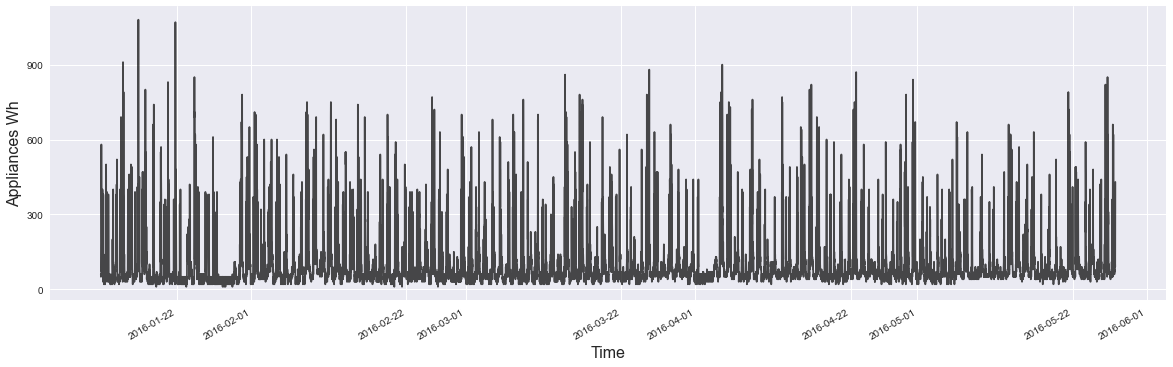

In [99]:
#training.Appliances.loc['2016'].resample('1d').plot(figsize=(14,6), c='blue', alpha = 0.7, grid=True, markersize=0.1)
#data.Appliances.loc['2016'].plot(figsize=(20,6), c='blue', alpha = 0.7, grid=True, markersize=0.5)

data.Appliances.plot(figsize=(20,6), c='black', alpha = 0.7, grid=True, markersize=0.5)
plt.yticks(np.arange(0, 1200, 300))
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Appliances Wh', fontsize = 16)
#plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))


plt.show()

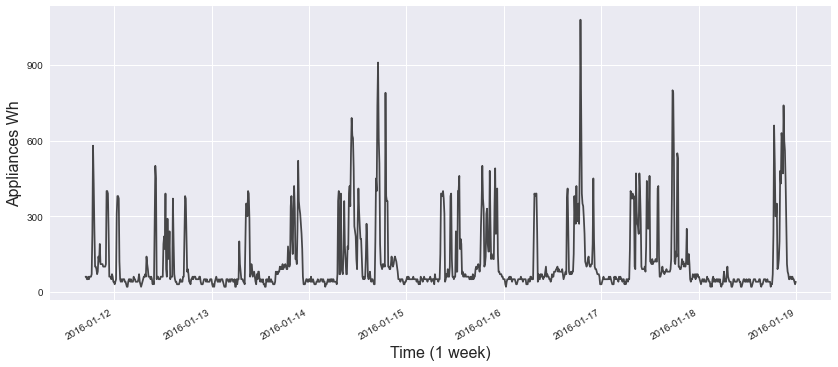

In [116]:
start, end = '2016-1-11', '2016-1-18'
data.Appliances.loc[start:end].plot(figsize=(14,6), c='black', alpha = 0.7, grid=True)
plt.yticks(np.arange(0, 1200, 300))
plt.xlabel('Time (1 week)', fontsize = 16)
plt.ylabel('Appliances Wh', fontsize = 16)
#plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.show()

Fig 1. (A) Appliances energy consumption measurement for the whole period, (B) A closer look at the first week of data.

Text(0, 0.5, 'Frequency')

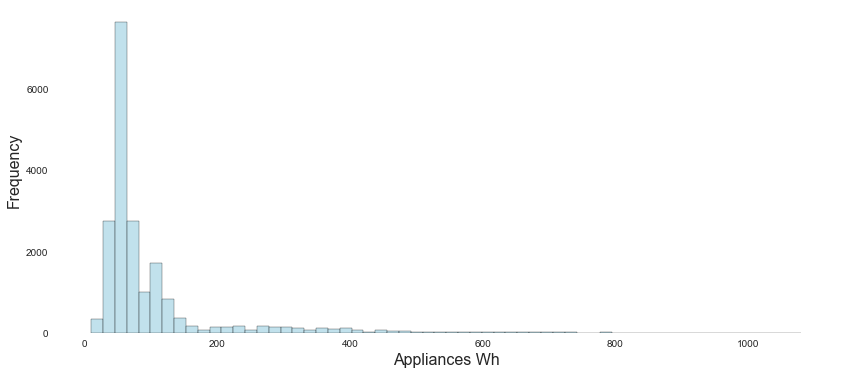

In [128]:

plt.figure(figsize=(14,6))
sns.histplot(data=data, x='Appliances', bins=60, color='lightblue').set_facecolor('xkcd:white')
plt.yticks(np.arange(0, 8000, 2000))
plt.xlabel('Appliances Wh', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)


Text(0.5, 0, 'Appliances Wh')

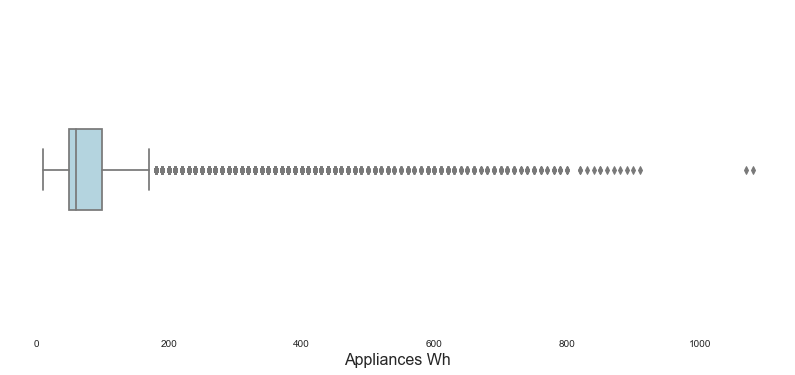

In [47]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Appliances', data=data, width=0.25, color='lightblue').set_facecolor('xkcd:white').
plt.xlabel('Appliances Wh', fontsize = 16)

Fig. 2. Appliances energy consumption distribution. Top: histogram, bottom: boxplot. The histogram shows the frequency of energy consumption in the interval (bar width), and the boxplot shows the location of the median with the black line.

Fig. 3 shows that there is a positive correlation between the energy consumption of appliances and lights (0.19). The second largest correlation is between appliances and T2. For the indoor temperatures, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air temperature differences between rooms. For example, a positive correlation is found with T1 and T3.

In [ ]:
data1=data[0:20]
#data1
cols1 = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']
cols2 = ['Appliances', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6']
cols3 = ['Appliances', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']
cols4 = ['Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'NSM', 'T6']

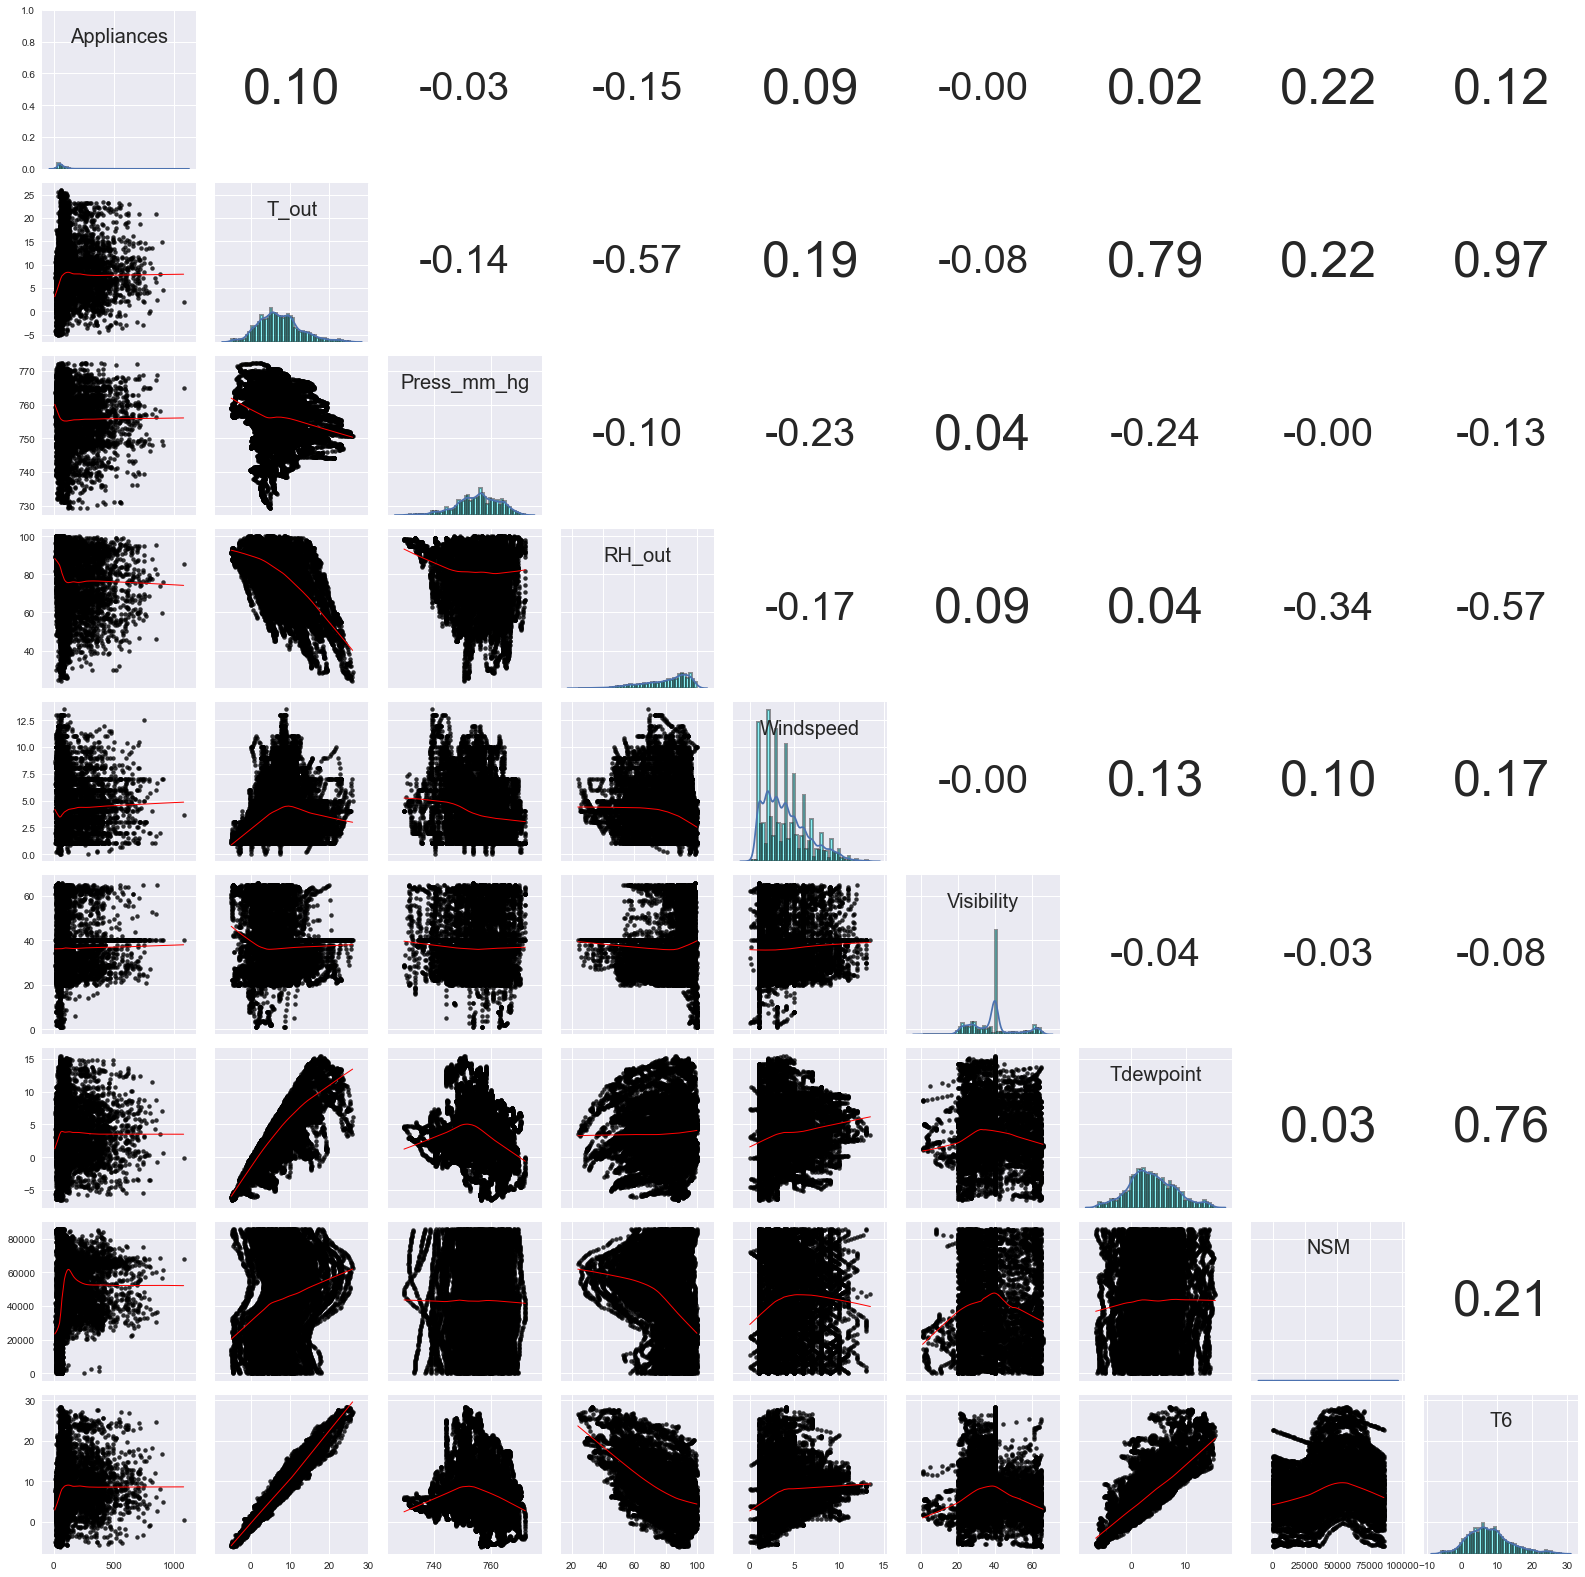

In [130]:
cols = iter(cols1)
    
#Upper    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}"
    ax = plt.gca()
    ax.set_axis_off()
    #set corr font size
    if corr_r < 0.0:
        font_size = 40
    if corr_r >= 0.0:
        font_size = 50
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    

#Diagonal
#Put variable names on diagonal of Seaborn PairGrid
def diagfunc(x, **kws):
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.5, 0.8), xycoords=ax.transAxes, fontsize = 20, ha="center")
    
#PairGrid
g = sns.PairGrid(training, vars=cols4).map_diag(diagfunc)

g.map_upper(corrdot)

g.map_diag(sns.distplot, 
           hist_kws={'histtype': 'bar', 'lw': 2, 'edgecolor': 'k', 'facecolor':'aqua'})


g.map_lower(sns.regplot, lowess=True, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 20})


#Remove the normal axis titles
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    #ax.xaxis.set_major_locator(ticker.MaxNLocator(4))

plt.show()
#----------------------------

In [16]:
#data_corr=data.corr()
#data_corr

Fig. 4. Hourly energy consumption of appliances heat map for four consecutive weeks.

In [61]:
#get Hour from strftime
data['Hour_of_day'] = data.index.strftime("%H") 
data['Hour_of_day'] = data['Hour_of_day'].astype(int) #convert from datetime object to int
#create Date from strftime
data['Date'] = data.index.strftime("%Y-%m-%d") 
#data.dtypes

In [62]:
#create new df 'Hourly_data' 
cols = ['Date', 'Hour_of_day', 'Day_of_week', 'Appliances']
Hourly_data = data[cols]
#Hourly_data #19735

In [63]:
#create column 'Days' to store the short name of Day_of_week
days = {'Monday':'Mon', 'Tuesday':'Tues', 'Wednesday':'Weds', 'Thursday':'Thurs', 'Friday':'Fri', 'Saturday':'Sat','Sunday':'Sun'}
Hourly_data['Days'] = Hourly_data['Day_of_week'].apply(lambda x: days[x])
#re-order Days column
Hourly_data['Days'] = pd.Categorical(Hourly_data['Days'], categories=['Sun', 'Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat'], ordered=True)

#drop Day_of_week column
drop_cols = ['Day_of_week'] #drop Appliances column
Hourly_data.drop(drop_cols, axis=1, inplace=True)

#Calculate the maximum of Appliances
max_value = Hourly_data.groupby(['Date','Hour_of_day'])['Appliances'].transform('sum').max()
#max_value #3650

#Hourly_data

In [24]:
#Hourly[Hourly['Houly_App'] >= 3000] 
#start, end = '2016-01-17', '2016-02-06' #date rage on pdf
#start, end = '2016-03-01', '2016-03-28' 
#Hourly.loc[start:end]


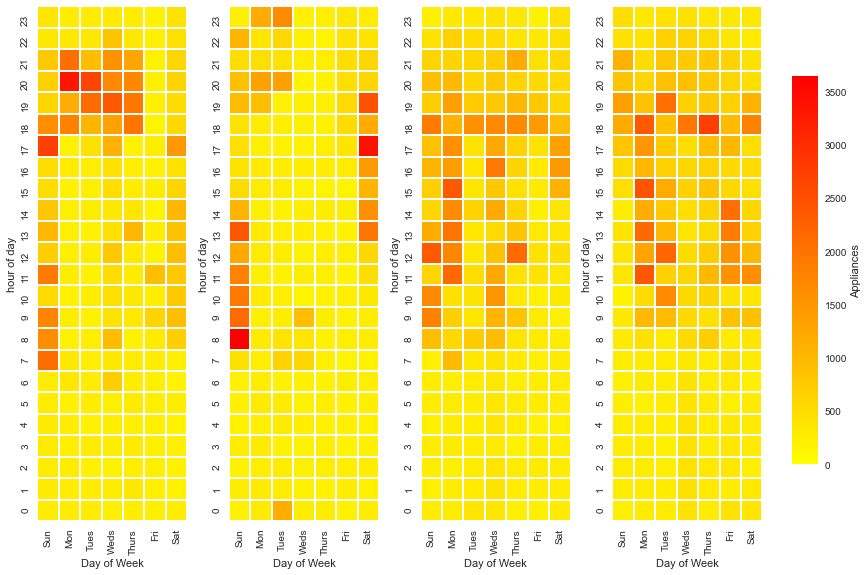

In [112]:
Week1 = Hourly_data.loc['2016-01-17':'2016-01-23']
Week2 = Hourly_data.loc['2016-01-24':'2016-01-30']
Week3 = Hourly_data.loc['2016-01-31':'2016-02-06']
Week4 = Hourly_data.loc['2016-02-07':'2016-02-13']

#reshape the data in long form to wide form using Pandas’s pivot_table() function.
heatmap_data1 = pd.pivot_table(Week1, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data2 = pd.pivot_table(Week2, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data3 = pd.pivot_table(Week3, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')
heatmap_data4 = pd.pivot_table(Week4, values='Appliances', index=['Hour_of_day'], columns='Days', aggfunc='sum')

#create list 'Hours' to store the reverse sorted of Hour_of_day
Hours=Hourly_data.Hour_of_day.unique().tolist()
Hours=sorted(Hours, reverse=True)

heatmap_data1=heatmap_data1.loc[Hours]
heatmap_data2=heatmap_data2.loc[Hours]
heatmap_data3=heatmap_data3.loc[Hours]
heatmap_data4=heatmap_data4.loc[Hours]


fig, ax = plt.subplots(1, 4, figsize = (12, 18))
#make an axis for the colorbar on the right side
cbar_ax = fig.add_axes([.91, .35, .03, .3])
fig.tight_layout(rect=[0, 0, .9, 1])
#cbar.ax.set_yticklabels(['0','1000','2000','3000'])

g1 = sns.heatmap(heatmap_data1, ax=ax[0], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day')

g2 = sns.heatmap(heatmap_data2, ax=ax[1], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day')

g3 = sns.heatmap(heatmap_data3, ax=ax[2], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value, 
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day')

g4 = sns.heatmap(heatmap_data4, ax=ax[3], cmap='autumn_r',square=True, cbar = True, cbar_ax=cbar_ax, vmin=0, vmax=max_value,  
              cbar_kws={'fraction' : 0.01, 'label': 'Appliances'}, linewidth=1).set(xlabel='Day of Week', ylabel='hour of day')
#("ticks":np.arange(0,22))
#g1.xticks(rotation=0) 
#plt.xticks(rotation=0) 
#plt.yticks(rotation=0) 
#plt.xticks(fontsize="15")

#fig = gcf()
ax = fig.gca()


plt.show()